# RNN Model

In this file, I will use the RNN (Recursion neural network) model from torch.nn library and try to recreate it with basic component like Linear layer to better understand the architecture of this model


## 1. Get the data
I will use the data downloaded from Kaggle

In [40]:
# Load dataset from datasets folder
import os
import pandas as pd
import torch
from pathlib import Path
folder_path = Path("../datasets/daily-climate-time-series-data/")
train_path = folder_path / "DailyDelhiClimateTrain.csv"
test_path = folder_path / "DailyDelhiClimateTest.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print(df_train.head())
print(df_test.head())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333


## 2. Explore the data (EDA)
First we leave the test set alone

In [41]:
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (1462, 5)
Shape of df_test: (114, 5)


In [42]:
print(df_train.describe())

          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


Check missing value

In [43]:
df_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [44]:
# Drop the date column
df_train.drop(columns="date", inplace=True)
df_test.drop(columns="date", inplace=True)

No missing value

Data visualization

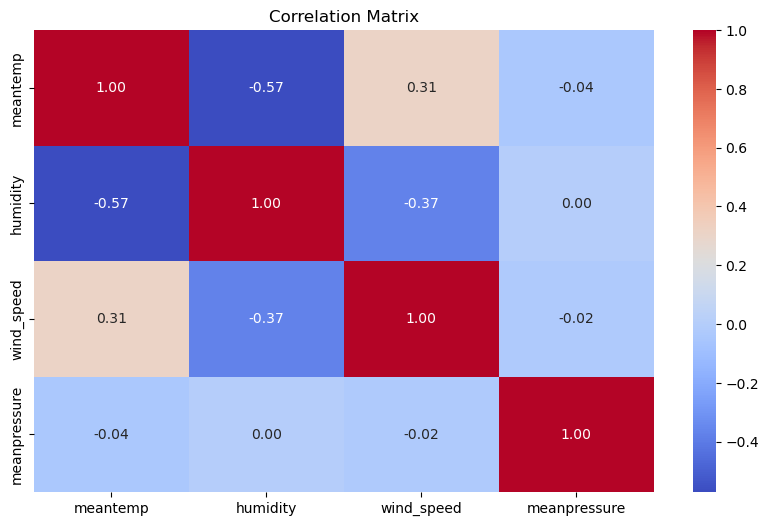

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

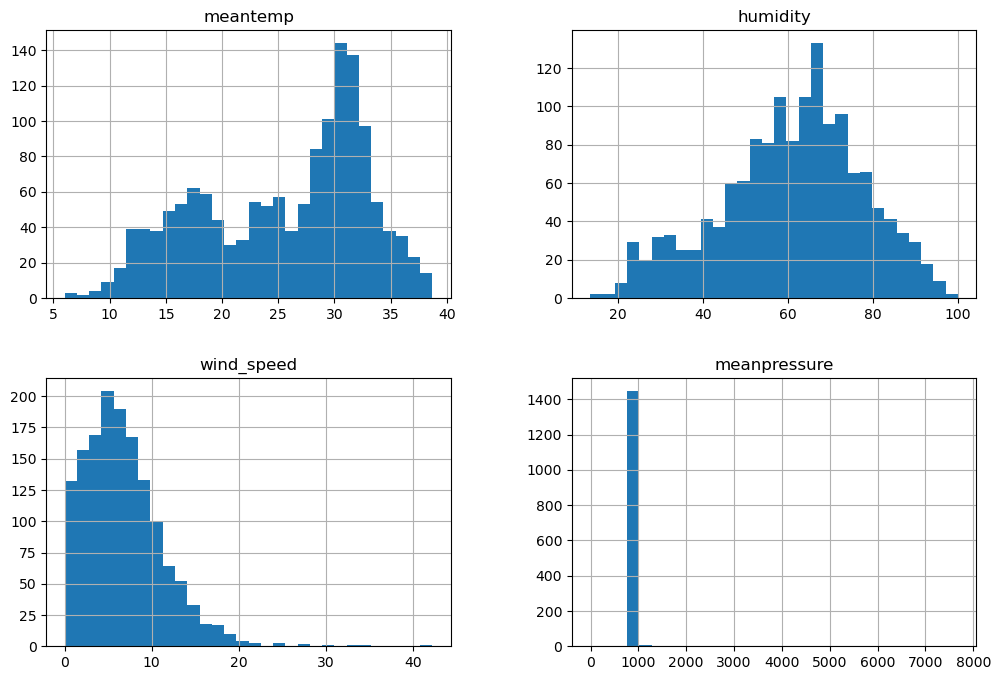

In [46]:
df_train.hist(figsize=(12, 8), bins=30)
plt.show()

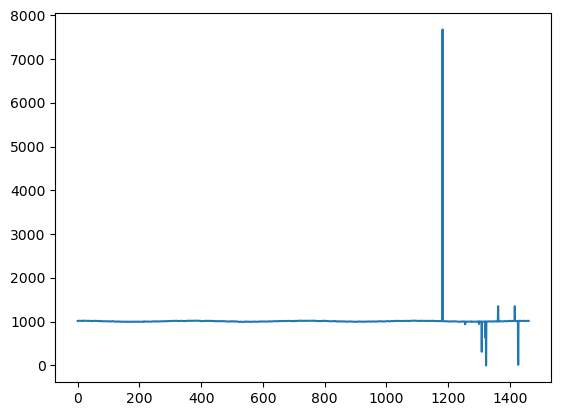

In [47]:
plt.plot(df_train["meanpressure"])

It look like that meanpressure doesnt have much information so we will remove this feature from the dataset

In [48]:
df_train = df_train["meantemp"]
df_test = df_test["meantemp"]
df_train.head()

0    10.000000
1     7.400000
2     7.166667
3     8.666667
4     6.000000
Name: meantemp, dtype: float64

In [49]:
df_train = df_train.values.reshape(-1,1)
df_test = df_test.values.reshape(-1,1)

## 3. Data preproccessing

In [50]:
len(df_train)

1462

In [51]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_train_scaler = std_scaler.fit_transform(df_train)
df_test_scaler = std_scaler.transform(df_test)

In [52]:
df_train_scaler = df_test_scaler.squeeze()
df_test_scaler = df_test_scaler.squeeze()

In [53]:
# Define train set and test set
# In this model, we will predict the mean temperature of the next day using 10 previous days
import numpy as np
def create_sequences(data, seq_length=1):
    out = []
    
    for i in range(len(data) - seq_length):
        feature = data[i:i+seq_length]  # Features
        target = data[i+seq_length]     # Target (meantemp)
        out.append((feature, target))
    return out

train_data = create_sequences(torch.tensor(df_train_scaler, dtype=torch.float32), 12)
test_data = create_sequences(torch.tensor(df_test_scaler, dtype=torch.float32), 12)

In [54]:
# turn train dataset into DataLoader
from torch.utils.data import DataLoader

# Set the batch size
BATCH_SIZE = 8

# turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b7b1963490>,
 <torch.utils.data.dataloader.DataLoader at 0x1b7bd650e90>)

In [55]:
len(train_dataloader)

13

In [56]:
train_dataloader.dataset[0]

(tensor([-1.3045, -0.9523, -1.1414, -0.9251, -0.9675, -0.8410, -1.4685, -1.3357,
         -1.4872, -1.8221, -1.9734, -1.8659]),
 tensor(-1.6691))

## 4. Create RNN model

In [57]:
import torch.nn as nn
from torch.optim import SGD
from torch.nn import MSELoss, L1Loss

Create device agnostic code

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers,
                                batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x: torch.Tensor):
        # Initialize hidden state with zeros   
        hidden = torch.zeros(self.num_layers, self.hidden_size).to(device)       
        # One time step
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out) 
        return out

rnn_model = RNNModel(input_size=12,
                         hidden_size=512,
                         num_layers=5,
                         output_size=1).to(device)
optimizer = SGD(params=rnn_model.parameters(),
                 lr=0.022)

loss_fn = nn.MSELoss()


## 5. Create Training loop

In [60]:
from tqdm import tqdm
import time

In [62]:
from general_functions import *
train_loss_history = []
test_loss_history = []
EPOCHS = 30

for epoch in tqdm(range(EPOCHS)):
    train_loss_history.append(train_step_regression(
        model=rnn_model,                                                    
        data_loader=train_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device))
    
    test_loss_history.append(test_step_regression(
        model=rnn_model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        device=device
    ))
    

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\letha\anaconda3\envs\Face-mask-detection-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\letha\anaconda3\envs\Face-mask-detection-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


In [63]:
test_dataloader.dataset[1]

(tensor([-0.9523, -1.1414, -0.9251, -0.9675, -0.8410, -1.4685, -1.3357, -1.4872,
         -1.8221, -1.9734, -1.8659, -1.6691]),
 tensor(-1.6739))

In [64]:
preds, targets = [], []
hidden = None
last_inputs = None

month = 48

with torch.no_grad():
    rnn_model.eval() 
    for inputs, target in test_dataloader: 
        output = rnn_model(inputs)
        preds += output.flatten().tolist()
        targets += target.flatten().tolist()
        last_inputs = inputs

    n_forecast = int(np.ceil(month/len(last_inputs)))

    for i in range(int(n_forecast)):
        # take last prediction result for new input
        pred_inputs = (last_inputs[-1][1:]).tolist()
        pred_inputs.append(preds[-1])
        
        # create new input format for models
        forecast_inputs = last_inputs[1:].tolist()
        forecast_inputs.append(pred_inputs)
        forecast_inputs = torch.tensor(forecast_inputs)
        
        # forecast and saving the result
        output = rnn_model(forecast_inputs)
        last_inputs = forecast_inputs
        preds += output.flatten().tolist()

# inverse the result since we use scaling on our data
preds = std_scaler.inverse_transform(pd.DataFrame(preds))
targets = std_scaler.inverse_transform(pd.DataFrame(targets))

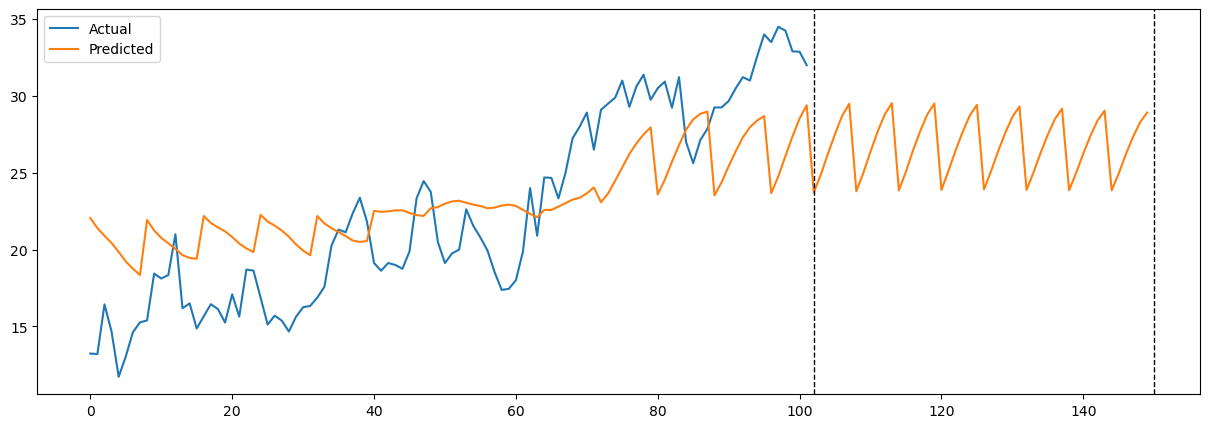

In [65]:
# Plot the predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(targets, label='Actual')
plt.plot(preds, label='Predicted')

plt.axvline(len(test_data), color='k', linestyle="--", linewidth=1)
plt.axvline(len(test_data) + n_forecast*len(last_inputs), color='k', linestyle="--", linewidth=1)

plt.legend()
plt.show()